In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,UpSampling2D
import cv2
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
!unzip /content/drive/MyDrive/M_citrus-20240301T131135Z-001.zip

Archive:  /content/drive/MyDrive/M_citrus-20240301T131135Z-001.zip
   creating: M_citrus/mask/.ipynb_checkpoints/
  inflating: M_citrus/mask/g (6).png  
  inflating: M_citrus/mask/g (60).png  
  inflating: M_citrus/mask/g (91).png  
  inflating: M_citrus/mask/g (99).png  
  inflating: M_citrus/mask/g (88).png  
  inflating: M_citrus/mask/g (58).png  
  inflating: M_citrus/mask/g (47).png  
  inflating: M_citrus/mask/g (63).png  
  inflating: M_citrus/mask/g (52).png  
  inflating: M_citrus/mask/g (72).png  
  inflating: M_citrus/legiont/image/img/g (51).png  
  inflating: M_citrus/legiont/image/img/28.pn.png  
  inflating: M_citrus/mask/g (44).png  
  inflating: M_citrus/mask/g (97).png  
  inflating: M_citrus/mask/g (84).png  
  inflating: M_citrus/mask/g (98).png  
  inflating: M_citrus/legiont/image/img/g (165).png  
  inflating: M_citrus/mask/g (42).png  
  inflating: M_citrus/mask/g (4).png  
  inflating: M_citrus/mask/g (86).png  
  inflating: M_citrus/mask/78.png    
  inflating

In [ ]:
image_source_dir = "/content/M_citrus/images"
mask_source_dir = "/content/M_citrus/mask"

# Destination directories for train and val
train_image_dir = "/content/M_citrus/legion/image/img"
train_mask_dir = "/content/M_citrus/legionm/mask/img"
test_image_dir = "/content/M_citrus/legiont/image/img"

# Create train and val directories
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

# List all image and mask files
image_files = os.listdir(image_source_dir)
mask_files = os.listdir(mask_source_dir)

# Set the proportion of data to be used for validation
validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files)-num_validation_samples

# Randomly shuffle the list of files
random.shuffle(image_files)

# # Move files to train and val directories
# for i, image_file in enumerate(image_files):
#     source_image_path = os.path.join(image_source_dir, image_file)
#     source_mask_file = os.path.splitext(image_file)[0] + ".png"
#     source_mask_path = os.path.join(mask_source_dir, source_mask_file)
#     shutil.copy(source_image_path, os.path.join(train_image_dir, image_file))
#     shutil.copy(source_mask_path, os.path.join(train_mask_dir, source_mask_file))

# random.shuffle(image_files)

# for i, image_file in enumerate(image_files):
#     source_image_path = os.path.join(image_source_dir, image_file)
#     shutil.copy(source_image_path, os.path.join(test_image_dir, image_file))

print("Data separation complete.")

Data separation complete.


In [ ]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


print('Resizing training images and masks')
for i in tqdm(range(num_train_samples), desc='Processing images'):
    img_path = os.path.join(train_image_dir, image_files[i])
    source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
    mask_path = os.path.join(train_mask_dir, source_mask_file)

    img = Image.open(img_path)
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[i] = mask


X_test = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')
for i in tqdm(range(num_validation_samples), desc='Processing images'):
    img_path = os.path.join(test_image_dir, image_files[i])
    img = Image.open(img_path)
    img = np.array(img)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

Resizing training images and masks


Processing images: 100%|██████████| 431/431 [00:08<00:00, 52.36it/s]


Resizing test images


Processing images: 100%|██████████| 107/107 [00:01<00:00, 56.40it/s]


In [ ]:
# Load your datasets
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to load images into arrays
def load_images_from_directory(directory, target_size=(128, 128)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)

# Load your datasets
X_train_overlayed = load_images_from_directory(train_overlayed_dir)
Y_train = load_images_from_directory(train_mask_dir, target_size=(128, 128))
X_val = load_images_from_directory(test_image_dir)
Y_val = load_images_from_directory(test_overlayed_dir)

# Make sure that the masks are in a binary format
Y_train = (Y_train > 0).astype(np.uint8)
Y_val = (Y_val > 0).astype(np.uint8)

# Normalize the images
X_train_overlayed = X_train_overlayed / 255.0
X_val = X_val / 255.0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Add, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# def conv_block(input_tensor, num_filters, kernel_size=3, activation='relu'):
#     x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(input_tensor)
#     x = BatchNormalization()(x)
#     x = Activation(activation)(x)
#     return x
def conv_block(input_tensor, num_filters, kernel_size=3, activation='relu'):
    x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same', kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

inputs = Input(shape=(128, 128, 3))

# Encoder with leaky_relu activation
x1, p1 = encoder_block(inputs, 32)
x1 = LeakyReLU(alpha=0.1)(x1)
x2, p2 = encoder_block(p1, 64)
x2 = LeakyReLU(alpha=0.1)(x2)
b = conv_block(p2, 128)

# Decoder with residual connections
d2 = decoder_block(b, x2, 64)
d1 = decoder_block(d2, x1, 32)

# # Output layer with sigmoid activation
# outputs = Conv2D(3, (1, 1), activation='sigmoid')(d1)
# Output layer with sigmoid activation for binary segmentation
outputs = Conv2D(1, (1, 1), activation='sigmoid')(d1)
model = Model(inputs=[inputs], outputs=[outputs])

# Compile the model with binary_crossentropy loss and an Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=20)

Epoch 1/20
194/194 [==============================] - 8s 10ms/step - loss: 0.4249 - accuracy: 0.8705 - val_loss: 0.4360 - val_accuracy: 0.8934
Epoch 2/20
194/194 [==============================] - 2s 8ms/step - loss: 0.2668 - accuracy: 0.9343 - val_loss: 0.2547 - val_accuracy: 0.9406
Epoch 3/20
194/194 [==============================] - 2s 8ms/step - loss: 0.2264 - accuracy: 0.9419 - val_loss: 0.2029 - val_accuracy: 0.9519
Epoch 4/20
194/194 [==============================] - 2s 10ms/step - loss: 0.2077 - accuracy: 0.9429 - val_loss: 0.1898 - val_accuracy: 0.9514
Epoch 5/20
194/194 [==============================] - 2s 11ms/step - loss: 0.1913 - accuracy: 0.9458 - val_loss: 0.1629 - val_accuracy: 0.9570
Epoch 6/20
194/194 [==============================] - 2s 9ms/step - loss: 0.1818 - accuracy: 0.9450 - val_loss: 0.1490 - val_accuracy: 0.9604
Epoch 7/20
194/194 [==============================] - 3s 14ms/step - loss: 0.1723 - accuracy: 0.9466 - val_loss: 0.1667 - val_accuracy: 0.9447
Ep

4/4 [==============================] - 1s 229ms/step
The leaf area is 5701.0 pixels.


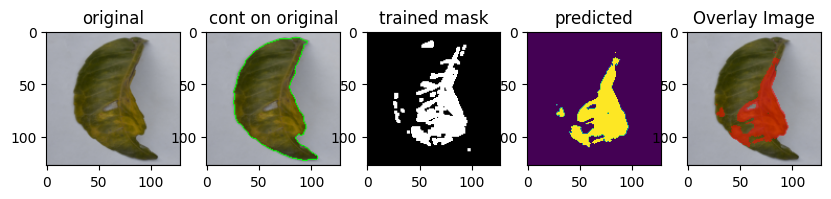

The affected area is 2038 pixels.


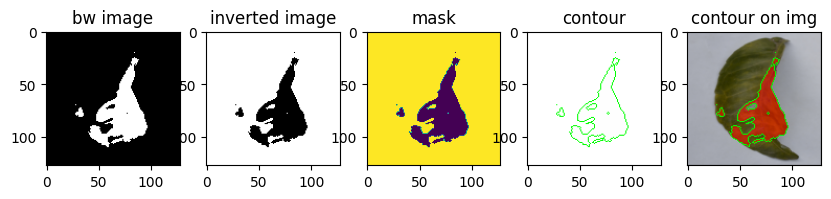

leaf region 2960.0


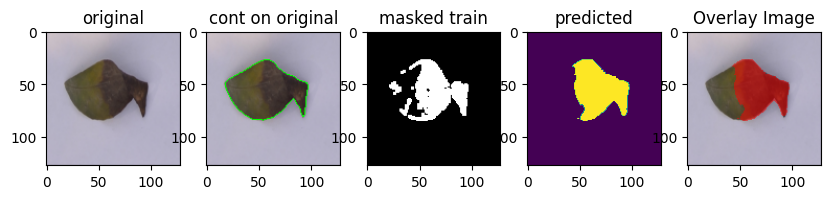

The affected area is 2045 pixels.


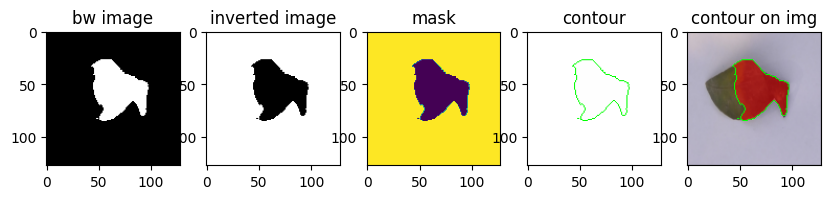

In [ ]:
idx = 7

idx = 5


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

def overlay_mask_on_image(image, mask, alpha=0.5):
    # Assuming mask is a color image with the same dimensions as the input image
    # and the mask's positive areas are represented by non-black pixels.

    # Create an overlay mask where the mask is not black
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)

    # Create an RGB version of the binary overlay mask
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    # Overlay the mask on the image
    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image

# Perform a sanity check on some random training samples111111
ix = random.randint(0, len(preds_train_t))
selected_image = X_train[ix]
im1 = selected_image
ground_truth_mask = Y_train[ix]
selected_mask = preds_train_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('original')
plt.imshow(selected_image)
# Convert the image to grayscale
gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(im1, contours1, -1, (0, 255, 0), 1)

# Calculate the area of each contour
t_area = 0
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    t_area += area

print(f"The leaf area is {t_area} pixels.")
plt.subplot(1,5,2)
plt.title('cont on original')
plt.imshow(im1)

# imshow(np.squeeze(Y_train[ix]))222222train masked image
# data1 = np.squeeze(Y_train[ix])
plt.subplot(1,5,3)
plt.title('trained mask')
plt.imshow(ground_truth_mask,cmap='gray')  # Add cmap='gray' if the image is grayscale

#33333333333333predection of training set
# data = np.squeeze(preds_train_t[ix])
plt.subplot(1,5,4)
plt.title('predicted')
plt.imshow(selected_mask)

plt.subplot(1, 5, 5)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

# Load the image
image = selected_mask

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
# total_area = 0
# # Calculate the area of each contour
# for j, contour in enumerate(contours):
#     area1 = cv2.contourArea(contour)
#     # print(f"Leaf {j+1} area: {area1} pixels")
#     total_area += area1
# Calculate pixel area of the overlay image
overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


#Perform a sanity check on some random validation samples4444441111111-----------------------------------------------------------
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
selected_image = X_train[int(X_train.shape[0]*0.9):][ix]
im = selected_image
ground_truth_mask = np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
selected_mask = preds_val_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

# ix = random.randint(0, len(preds_val_t))
# x2 = X_train[int(X_train.shape[0]*0.9):][ix]
# x1 = X_train[int(X_train.shape[0]*0.9):][ix]
plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('original')
plt.imshow(selected_image)
# Convert the image to grayscale
gray1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(im, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
print(f"leaf region {total_area1}")
plt.subplot(1,5,2)
plt.title('cont on original')
plt.imshow(im)


#555555555555222222222222
# data1 =np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
plt.subplot(1,5,3)
plt.title('masked train')
plt.imshow(ground_truth_mask,cmap= 'gray')


# 666666666666333333333333predict of validation set---------------------------
# data = np.squeeze(preds_val_t[ix])

plt.subplot(1,5,4)
plt.title('predicted')
plt.imshow(selected_mask)

plt.subplot(1, 5, 5)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

# Load the image
image = selected_mask

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image2 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image2, contours, -1, (0, 255, 0), 1)
# total_area = 0
# # Calculate the area of each contour
# for j, contour in enumerate(contours):
#     area1 = cv2.contourArea(contour)
#     # print(f"Leaf {j+1} area: {area1} pixels")
#     total_area += area1

overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image2)
# Display all subplots
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, applications, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras import metrics

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
# Images are RGB
CHANNELS=3
EPOCHS=15

In [ ]:
!unzip /content/drive/MyDrive/en_cit_aug-20240412T062506Z-001.zip

Archive:  /content/drive/MyDrive/en_cit_aug-20240412T062506Z-001.zip
  inflating: en_cit_aug/blackspot_a/b (75)_rotated_90_1.png  
  inflating: en_cit_aug/blackspot_a/b (166)_rotated_0_1.png  
  inflating: en_cit_aug/blackspot_a/b (85)_rotated_0_0.5.png  
  inflating: en_cit_aug/blackspot_a/b (166)_rotated_90_1.png  
  inflating: en_cit_aug/blackspot_a/b (166)_rotated_0_0.5.png  
  inflating: en_cit_aug/blackspot_a/b (75)_rotated_0_1.png  
  inflating: en_cit_aug/blackspot_a/b (24)_rotated_90_0.5.png  
  inflating: en_cit_aug/blackspot_a/b (234)_rotated_90_1.png  
  inflating: en_cit_aug/blackspot_a/b (24)_reflected_y.png  
  inflating: en_cit_aug/blackspot_a/b (166)_reflected_x.png  
  inflating: en_cit_aug/blackspot_a/b (234)_rotated_0_0.5.png  
  inflating: en_cit_aug/blackspot_a/b (85)_reflected_xy.png  
  inflating: en_cit_aug/blackspot_a/b (24)_reflected_x.png  
  inflating: en_cit_aug/blackspot_a/b (75)_reflected_y.png  
  inflating: en_cit_aug/blackspot_a/b (75)_rotated_90_0.5.

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/en_cit_aug",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4018 files belonging to 4 classes.


In [ ]:
class_names=dataset.class_names
class_names

['blackspot_a', 'canker_a', 'greening_a', 'healthy_a']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[0 2 0 1 2 1 2 0 2 2 3 2 2 2 0 2]


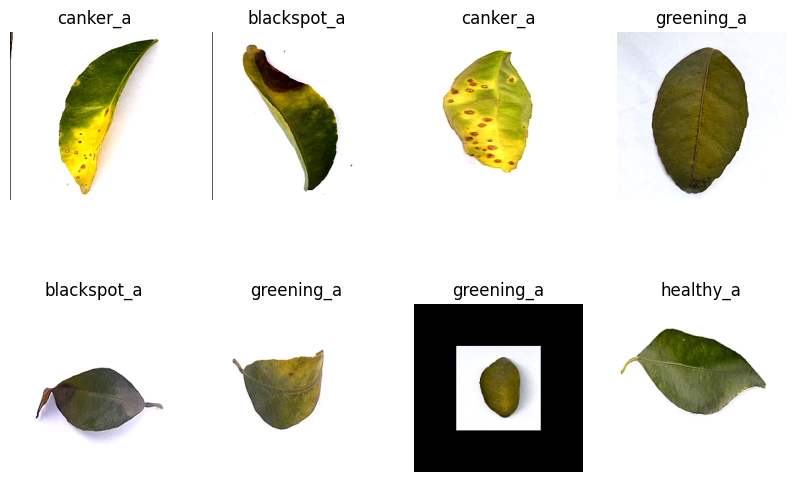

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

252

In [ ]:
test_ds = dataset.skip(30)
len(test_ds)

222

In [ ]:
val_size=0.1
len(dataset)*val_size

25.200000000000003

In [ ]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [ ]:
test_ds = test_ds.skip(3)
len(test_ds)

219

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

201

In [ ]:
len(val_ds)

25

In [ ]:
len(test_ds)

26

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Define the input shape and number of classes
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

# Use VGG16 as the base model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# Freeze all layers except the last four
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create the improved model
model2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.Dropout(0.5),  # Add Dropout
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower learning rate to fine-tune
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/18
201/201 [==============================] - 65s 231ms/step - loss: 0.9766 - accuracy: 0.6780 - val_loss: 1.9471 - val_accuracy: 0.6350 - lr: 1.0000e-04
Epoch 2/18
201/201 [==============================] - 37s 184ms/step - loss: 0.4295 - accuracy: 0.8410 - val_loss: 0.6324 - val_accuracy: 0.8275 - lr: 1.0000e-04
Epoch 3/18
201/201 [==============================] - 36s 180ms/step - loss: 0.4298 - accuracy: 0.8576 - val_loss: 0.5143 - val_accuracy: 0.8350 - lr: 1.0000e-04
Epoch 4/18
201/201 [==============================] - 38s 188ms/step - loss: 0.2546 - accuracy: 0.9169 - val_loss: 3.2274 - val_accuracy: 0.5350 - lr: 1.0000e-04
Epoch 5/18
201/201 [==============================] - 39s 195ms/step - loss: 0.1934 - accuracy: 0.9347 - val_loss: 3.5697 - val_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 6/18
201/201 [==============================] - 39s 193ms/step - loss: 0.1679 - accuracy: 0.9466 - val_loss: 0.1600 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 7/18
201/201 [========

1/1 [==============================] - 0s 33ms/step
              precision    recall  f1-score   support

 blackspot_a       0.97      1.00      0.99        99
    canker_a       1.00      1.00      1.00       130
  greening_a       1.00      0.98      0.99       154
   healthy_a       1.00      1.00      1.00        33

    accuracy                           0.99       416
   macro avg       0.99      1.00      0.99       416
weighted avg       0.99      0.99      0.99       416

              precision    recall  f1-score     support
blackspot_a    0.970588  1.000000  0.985075   99.000000
canker_a       1.000000  1.000000  1.000000  130.000000
greening_a     1.000000  0.980519  0.990164  154.000000
healthy_a      1.000000  1.000000  1.000000   33.000000
accuracy       0.992788  0.992788  0.992788    0.992788
macro avg      0.992647  0.995130  0.993810  416.000000
weighted avg   0.993001  0.992788  0.992807  416.000000


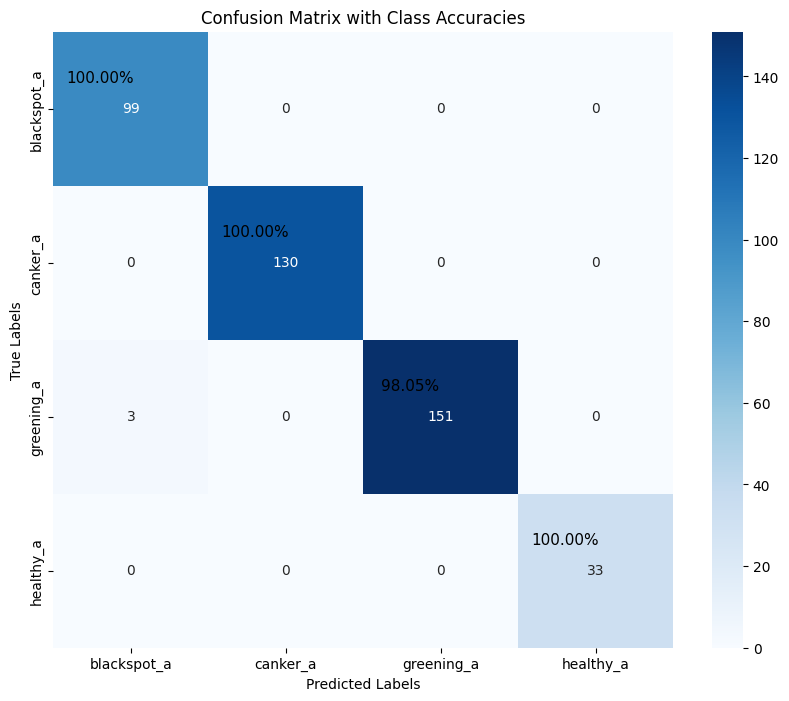

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
# ... [Your existing code for data loading and model definition] ...

# After training the model, evaluate it on the test dataset
def evaluate_model(model2, test_ds, class_names):
    y_true = []
    y_pred = []

    # Iterate over the test dataset to collect true labels and predictions
    for images, labels in test_ds:
        predictions = model2.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes)
    # Now you have all the true labels and predictions, you can generate the report
    print(classification_report(y_true, y_pred, target_names=class_names))
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Convert the report to a DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Display the DataFrame as a table
    print(report_df)
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy for each class
    accuracies = cm.diagonal() / cm.sum(axis=1)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Annotate each cell with the accuracy
    for i in range(cm.shape[0]):
        plt.text(i+0.3, i+0.3, f'{accuracies[i]:.2%}',
                 va='center', ha='center', color='black', fontsize=11)

    plt.title('Confusion Matrix with Class Accuracies')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# Call the evaluate_model function after model training
evaluate_model(model2, test_ds, class_names)

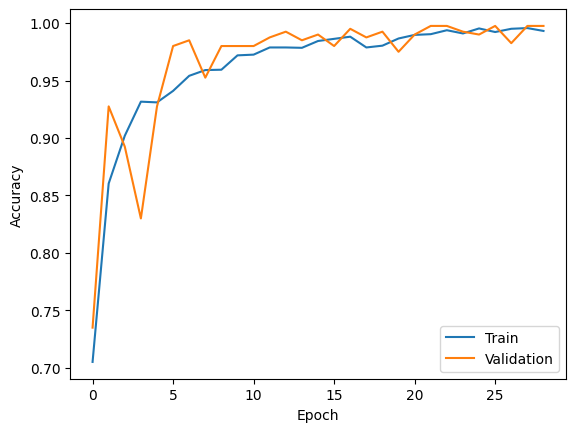

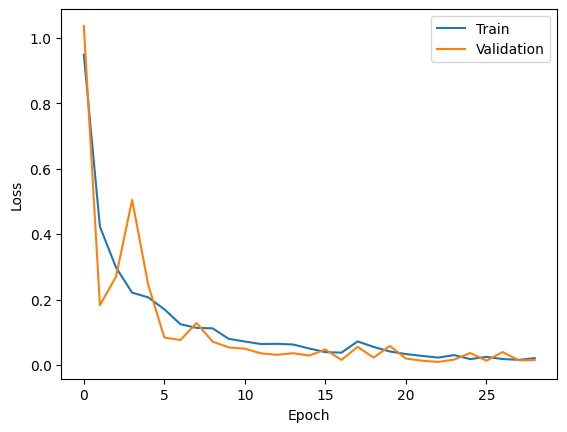

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(range(EPOCHS), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

unetacc = history.history['accuracy'][-1]

first image to predict
actual label: greening_a
1/1 [==============================] - 0s 476ms/step
predicted label: greening_a


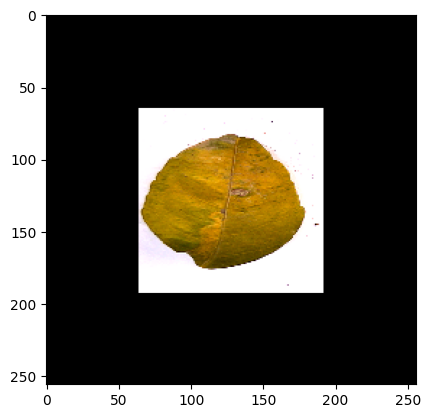

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model2.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model2, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model2.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


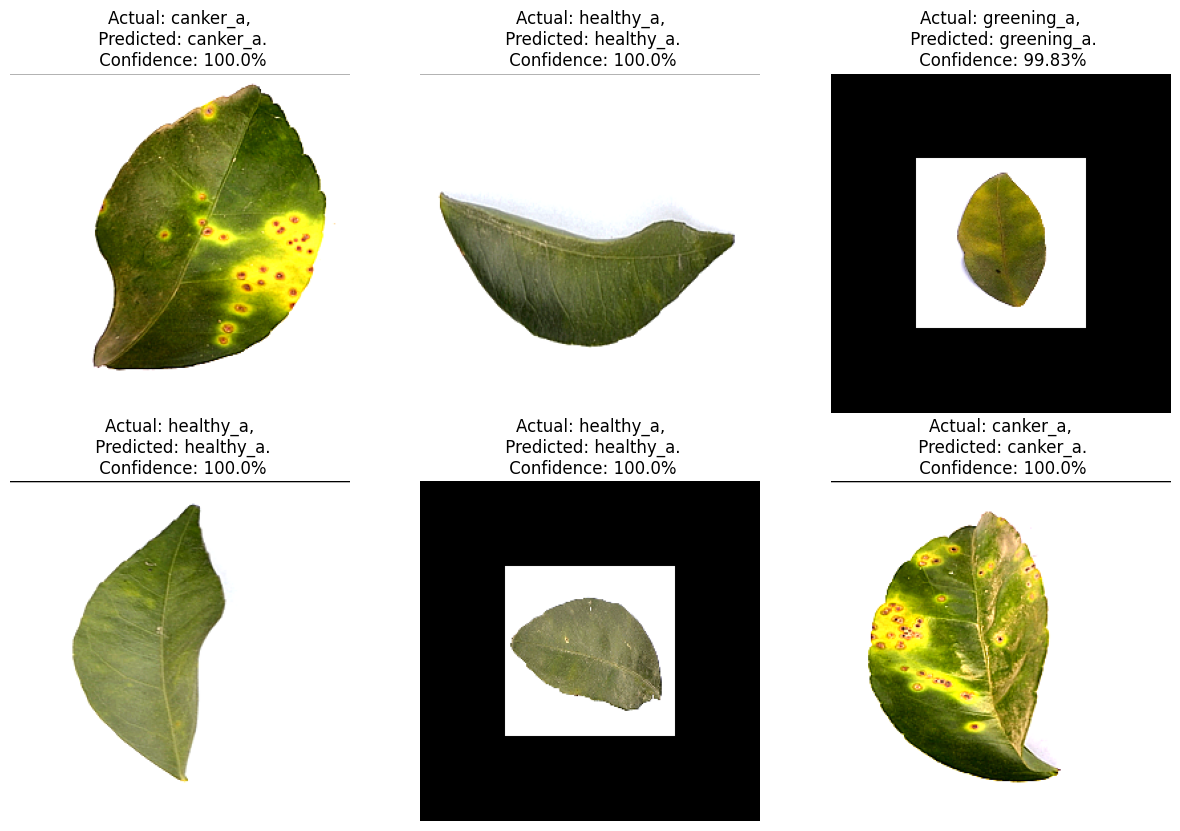

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model2, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 18ms/step
Predicted class: canker_a with confidence: 100.0%
1/1 [==============================] - 0s 17ms/step
The total area is 23957.0 pixels.


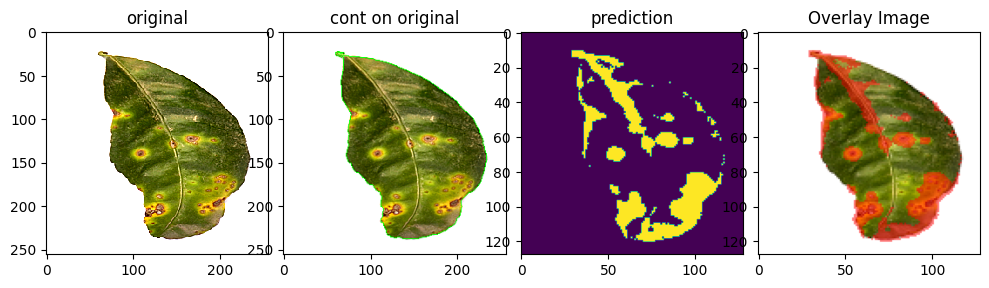

The affected area is 3601 pixels.


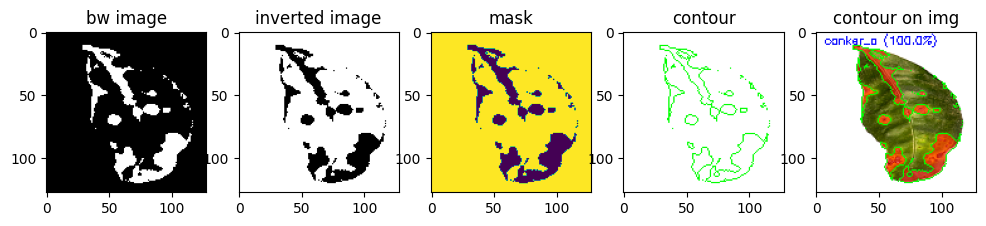

The ** **DISEASES AFFECTED area is 3601 pixels.
The total area is 3601 pixels.
Percentage of disease affected region 3601 is 15.03109738281087% of total leaf area 23957.0
Percentage of healthy region is: 84.96890261718913 


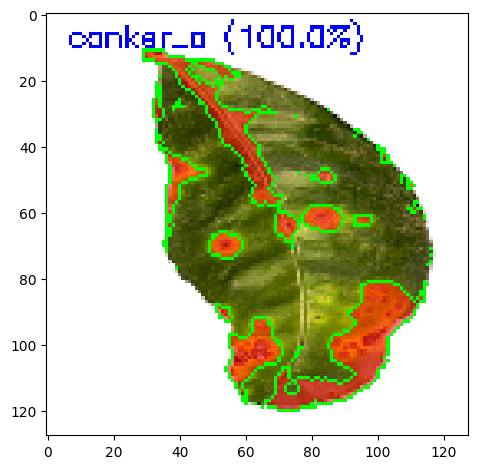

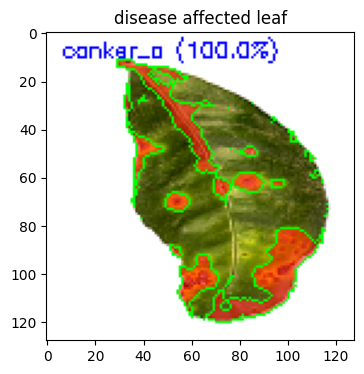

In [ ]:
from PIL import Image
import numpy as np


def overlay_mask_on_image(image, mask, alpha=0.5):
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image
# Load your image
image1 = Image.open('/content/drive/MyDrive/en_cit/canker_s/9.png.png')
image = image1




img = image1
image1=np.array(image1)
# Convert your image to numpy array
img = np.array(img)
im = image1

# Specify the dimensions to which you want to resize your image
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize your image
img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

# Now img_resized contains your resized image


# Preprocess your image to match the format expected by your model
# preprocessed_image = preprocess_image(new_image)

# Use your model to predict the segmentation of the image
preds_new = model.predict(np.expand_dims(img_resized, axis=0), verbose=1)

# Convert the predictions into binary format
preds_new_t = (preds_new > 0.5).astype(np.uint8)
# Overlay the mask on the original image
overlay_image = overlay_mask_on_image(img_resized, preds_new_t[0])

# Display the original image and the segmented image
plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.title('original')
imshow(im)
# plt.show()
# Convert the image to grayscale
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(img, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
# Display the image
#cv2.imshow('Image', img)
#
print(f"The total area is {total_area1} pixels.")
plt.subplot(1,4,2)
plt.title('cont on original')
plt.imshow(img)
# plt.show()
# imshow(np.squeeze(preds_new_t[0]))
# plt.show()

data = np.squeeze(preds_new_t[0])
plt.subplot(1,4,3)
plt.title('prediction')
plt.imshow(data)

plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

# Load the image
image = data

plt.figure(figsize=(12, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
cv2.putText(masked_image1, f"{predicted_class} ({confidence}%)", (6, 10), cv2.FONT_ITALIC, .3, (0, 0, 255), 1)

overlay_mask = np.any(data != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()

# Preprocess your image (resize if necessary, scale pixel values, etc.)
# image = image.resize((img_height, img_width))  # replace img_height and img_width with the dimensions your model expects
image = np.array(image) / 255.0  # scale pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # model.predict expects a batch of images
# image = image.numpy().astype("uint8")

# predicted_class, confidence = predict(model2, images[i].numpy())
# Use the model to predict the class
predicted_class, confidence = predict(model2, image)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")

print(f"The ** **DISEASES AFFECTED area is {overlay_image_area} pixels.")
print(f"The total area is {overlay_image_area} pixels.")
percentage = (overlay_image_area/total_area1)*100
print(f"Percentage of disease affected region {overlay_image_area} is {percentage}% of total leaf area {total_area1}")
healthy = 100 - percentage
print(f"Percentage of healthy region is: {healthy} ")
# plt.subplot(1,5,4)
# plt.title('contour')
# # plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
# plt.imshow(masked_image_rgb)
# plt.subplot(1,5,5)
# plt.title('contour on img')
# plt.imshow(masked_image1)
# Display all subplots

imshow(masked_image1)
plt.show()
plt.figure(figsize=(10, 4))
plt.subplot(1,1,1)
plt.title('disease affected leaf')
plt.imshow(masked_image1)

1/1 [==============================] - 0s 19ms/step
Predicted class: canker_a with confidence: 100.0%
1/1 [==============================] - 0s 28ms/step
The total area of leaf : 3894.5 pixels.


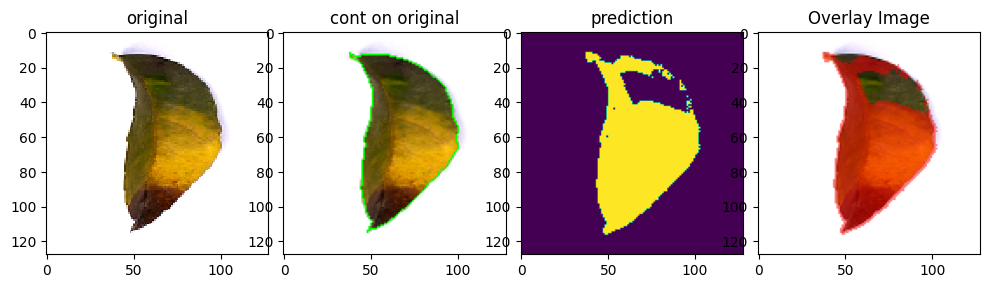

The affected area is 3675 pixels.


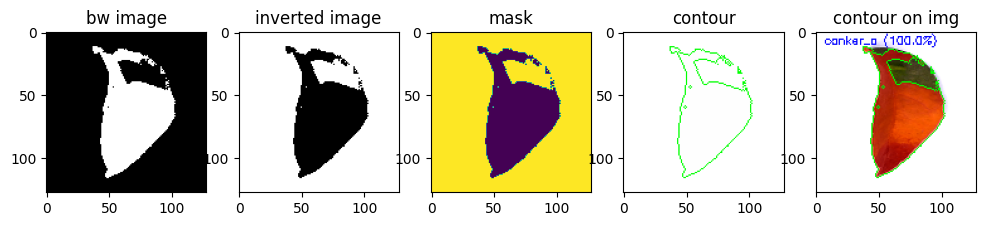

The ** **DISEASES AFFECTED area is 3675 pixels.
The total area is 3675 pixels.
Percentage of disease affected region 3675 is 94.36384645012197% of total leaf area 3894.5
Percentage of healthy region is: 5.636153549878031 


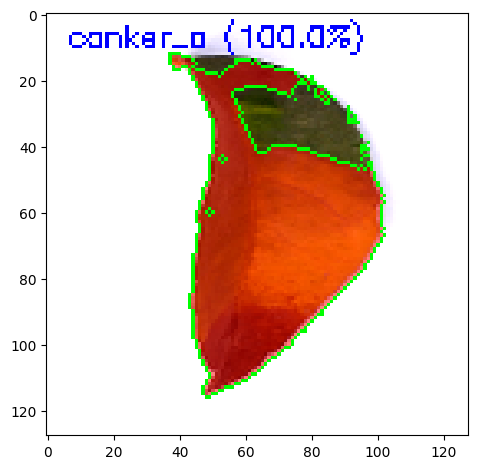

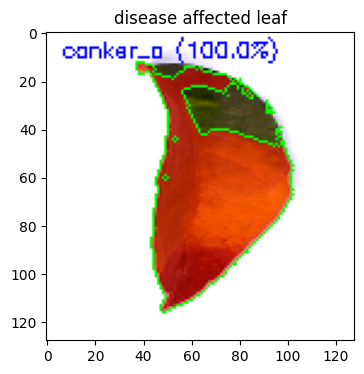

In [ ]:
from PIL import Image
import numpy as np


def overlay_mask_on_image(image, mask, alpha=0.5):
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image
# Load your image
image1 = Image.open('/content/drive/MyDrive/en_cit/blackspot_s/b (131).png')
image = image1
# Preprocess your image (resize if necessary, scale pixel values, etc.)
# image = image.resize((img_height, img_width))  # replace img_height and img_width with the dimensions your model expects
image = np.array(image) / 255.0  # scale pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # model.predict expects a batch of images
# image = image.numpy().astype("uint8")

# predicted_class, confidence = predict(model2, images[i].numpy())
# Use the model to predict the class
predicted_class, confidence = predict(model2, image)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")



img = image1
image1=np.array(image1)
# Convert your image to numpy array
img = np.array(img)


# Specify the dimensions to which you want to resize your image
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize your image
img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
im = img_resized
# Now img_resized contains your resized image


# Preprocess your image to match the format expected by your model
# preprocessed_image = preprocess_image(new_image)

# Use your model to predict the segmentation of the image
preds_new = model.predict(np.expand_dims(img_resized, axis=0), verbose=1)

# Convert the predictions into binary format
preds_new_t = (preds_new > 0.5).astype(np.uint8)
# Overlay the mask on the original image
overlay_image = overlay_mask_on_image(img_resized, preds_new_t[0])

# Display the original image and the segmented image
plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.title('original')
imshow(im)
# plt.show()
# Convert the image to grayscale
gray1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(im, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
# Display the image
#cv2.imshow('Image', img)
#
print(f"The total area of leaf : {total_area1} pixels.")
plt.subplot(1,4,2)
plt.title('cont on original')
plt.imshow(im)
# plt.show()
# imshow(np.squeeze(preds_new_t[0]))
# plt.show()

data = np.squeeze(preds_new_t[0])
plt.subplot(1,4,3)
plt.title('prediction')
plt.imshow(data)

plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

# Load the image
image = data

plt.figure(figsize=(12, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
cv2.putText(masked_image1, f"{predicted_class} ({confidence}%)", (6, 10), cv2.FONT_ITALIC, .3, (0, 0, 255), 1)

overlay_mask = np.any(preds_new_t[0] != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


print(f"The ** **DISEASES AFFECTED area is {overlay_image_area} pixels.")
print(f"The total area is {overlay_image_area} pixels.")
percentage = (overlay_image_area/total_area1)*100
print(f"Percentage of disease affected region {overlay_image_area} is {percentage}% of total leaf area {total_area1}")
healthy = 100 - percentage
print(f"Percentage of healthy region is: {healthy} ")
# plt.subplot(1,5,4)
# plt.title('contour')
# # plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
# plt.imshow(masked_image_rgb)
# plt.subplot(1,5,5)
# plt.title('contour on img')
# plt.imshow(masked_image1)
# Display all subplots

imshow(masked_image1)
plt.show()
plt.figure(figsize=(10, 4))
plt.subplot(1,1,1)
plt.title('disease affected leaf')
plt.imshow(masked_image1)

1/1 [==============================] - 0s 22ms/step
Predicted class: greening_a with confidence: 99.97%
1/1 [==============================] - 0s 20ms/step
The total area is 11344.5 pixels.


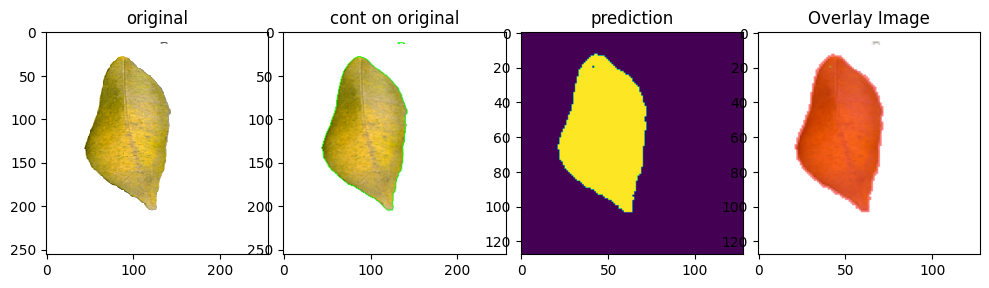

The affected area is 3601 pixels.


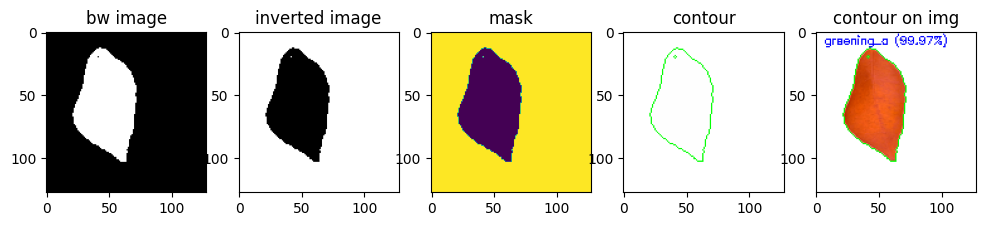

The ** **DISEASES AFFECTED area is 3601 pixels.
The total area is 3601 pixels.
Percentage of disease affected region 3601 is 31.742253955661333% of total leaf area 11344.5
Percentage of healthy region is: 68.25774604433866 


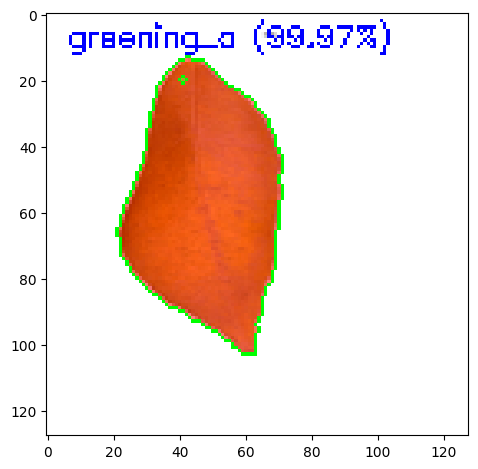

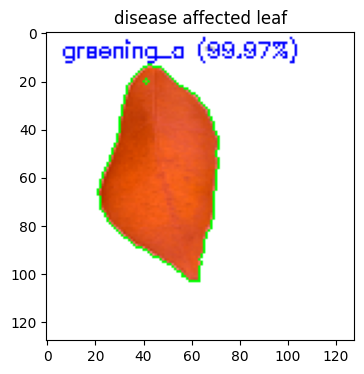

In [ ]:
from PIL import Image
import numpy as np


def overlay_mask_on_image(image, mask, alpha=0.5):
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image
# Load your image
image1 = Image.open('/content/drive/MyDrive/en_cit/greening_s/g (104).png')
image = image1
# Preprocess your image (resize if necessary, scale pixel values, etc.)
# image = image.resize((img_height, img_width))  # replace img_height and img_width with the dimensions your model expects
image = np.array(image) / 255.0  # scale pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # model.predict expects a batch of images
# image = image.numpy().astype("uint8")

# predicted_class, confidence = predict(model2, images[i].numpy())
# Use the model to predict the class
predicted_class, confidence = predict(model2, image)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")



img = image1
image1=np.array(image1)
# Convert your image to numpy array
img = np.array(img)
im = image1

# Specify the dimensions to which you want to resize your image
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize your image
img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

# Now img_resized contains your resized image


# Preprocess your image to match the format expected by your model
# preprocessed_image = preprocess_image(new_image)

# Use your model to predict the segmentation of the image
preds_new = model.predict(np.expand_dims(img_resized, axis=0), verbose=1)

# Convert the predictions into binary format
preds_new_t = (preds_new > 0.5).astype(np.uint8)
# Overlay the mask on the original image
overlay_image = overlay_mask_on_image(img_resized, preds_new_t[0])

# Display the original image and the segmented image
plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.title('original')
imshow(im)
# plt.show()
# Convert the image to grayscale
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(img, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
# Display the image
#cv2.imshow('Image', img)
#
print(f"The total area is {total_area1} pixels.")
plt.subplot(1,4,2)
plt.title('cont on original')
plt.imshow(img)
# plt.show()
# imshow(np.squeeze(preds_new_t[0]))
# plt.show()

data = np.squeeze(preds_new_t[0])
plt.subplot(1,4,3)
plt.title('prediction')
plt.imshow(data)

plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

# Load the image
image = data

plt.figure(figsize=(12, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
cv2.putText(masked_image1, f"{predicted_class} ({confidence}%)", (6, 10), cv2.FONT_ITALIC, .3, (0, 0, 255), 1)

overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


print(f"The ** **DISEASES AFFECTED area is {overlay_image_area} pixels.")
print(f"The total area is {overlay_image_area} pixels.")
percentage = (overlay_image_area/total_area1)*100
print(f"Percentage of disease affected region {overlay_image_area} is {percentage}% of total leaf area {total_area1}")
healthy = 100 - percentage
print(f"Percentage of healthy region is: {healthy} ")
# plt.subplot(1,5,4)
# plt.title('contour')
# # plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
# plt.imshow(masked_image_rgb)
# plt.subplot(1,5,5)
# plt.title('contour on img')
# plt.imshow(masked_image1)
# Display all subplots

imshow(masked_image1)
plt.show()
plt.figure(figsize=(10, 4))
plt.subplot(1,1,1)
plt.title('disease affected leaf')
plt.imshow(masked_image1)

1/1 [==============================] - 0s 21ms/step
Predicted class: greening_a with confidence: 99.97%
1/1 [==============================] - 0s 19ms/step
The total area is 21049.5 pixels.


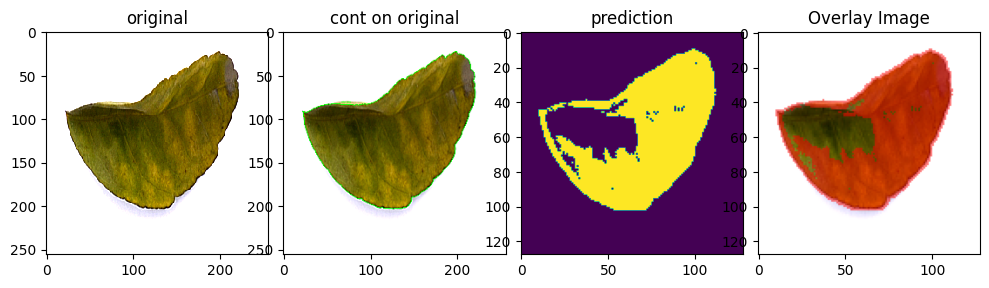

The affected area is 3601 pixels.


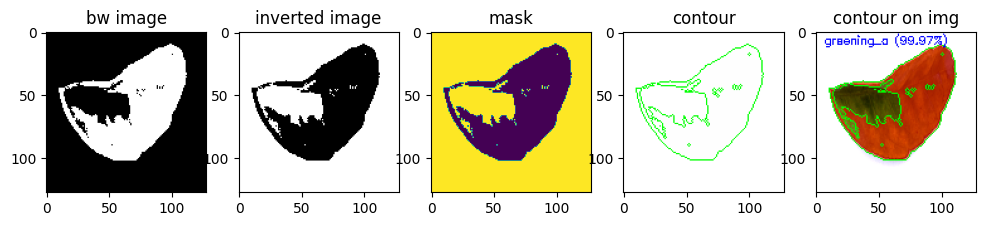

The ** **DISEASES AFFECTED area is 3601 pixels.
The total area is 3601 pixels.
Percentage of disease affected region 3601 is 17.107294710088127% of total leaf area 21049.5
Percentage of healthy region is: 82.89270528991187 


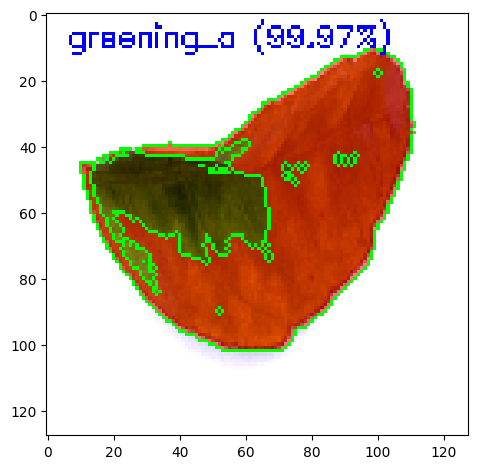

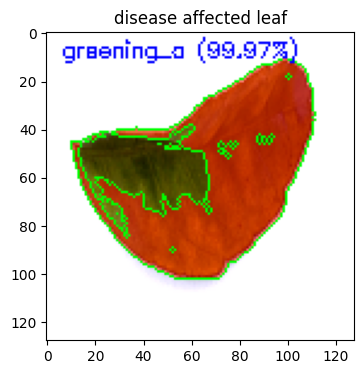

In [ ]:
from PIL import Image
import numpy as np


def overlay_mask_on_image(image, mask, alpha=0.5):
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image
# Load your image
image1 = Image.open('/content/drive/MyDrive/en_cit/greening_s/g (2).png')
image = image1
# Preprocess your image (resize if necessary, scale pixel values, etc.)
# image = image.resize((img_height, img_width))  # replace img_height and img_width with the dimensions your model expects
image = np.array(image) / 255.0  # scale pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # model.predict expects a batch of images
# image = image.numpy().astype("uint8")

# predicted_class, confidence = predict(model2, images[i].numpy())
# Use the model to predict the class
predicted_class, confidence = predict(model2, image)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")



img = image1
image1=np.array(image1)
# Convert your image to numpy array
img = np.array(img)
im = image1

# Specify the dimensions to which you want to resize your image
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize your image
img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

# Now img_resized contains your resized image


# Preprocess your image to match the format expected by your model
# preprocessed_image = preprocess_image(new_image)

# Use your model to predict the segmentation of the image
preds_new = model.predict(np.expand_dims(img_resized, axis=0), verbose=1)

# Convert the predictions into binary format
preds_new_t = (preds_new > 0.5).astype(np.uint8)
# Overlay the mask on the original image
overlay_image = overlay_mask_on_image(img_resized, preds_new_t[0])

# Display the original image and the segmented image
plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.title('original')
imshow(im)
# plt.show()
# Convert the image to grayscale
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(img, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
# Display the image
#cv2.imshow('Image', img)
#
print(f"The total area is {total_area1} pixels.")
plt.subplot(1,4,2)
plt.title('cont on original')
plt.imshow(img)
# plt.show()
# imshow(np.squeeze(preds_new_t[0]))
# plt.show()

data = np.squeeze(preds_new_t[0])
plt.subplot(1,4,3)
plt.title('prediction')
plt.imshow(data)

plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

# Load the image
image = data

plt.figure(figsize=(12, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
cv2.putText(masked_image1, f"{predicted_class} ({confidence}%)", (6, 10), cv2.FONT_ITALIC, .3, (0, 0, 255), 1)

overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


print(f"The ** **DISEASES AFFECTED area is {overlay_image_area} pixels.")
print(f"The total area is {overlay_image_area} pixels.")
percentage = (overlay_image_area/total_area1)*100
print(f"Percentage of disease affected region {overlay_image_area} is {percentage}% of total leaf area {total_area1}")
healthy = 100 - percentage
print(f"Percentage of healthy region is: {healthy} ")
# plt.subplot(1,5,4)
# plt.title('contour')
# # plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
# plt.imshow(masked_image_rgb)
# plt.subplot(1,5,5)
# plt.title('contour on img')
# plt.imshow(masked_image1)
# Display all subplots

imshow(masked_image1)
plt.show()
plt.figure(figsize=(10, 4))
plt.subplot(1,1,1)
plt.title('disease affected leaf')
plt.imshow(masked_image1)

1/1 [==============================] - 0s 19ms/step
Predicted class: greening_a with confidence: 99.97%
1/1 [==============================] - 0s 19ms/step
The total area is 26719.5 pixels.


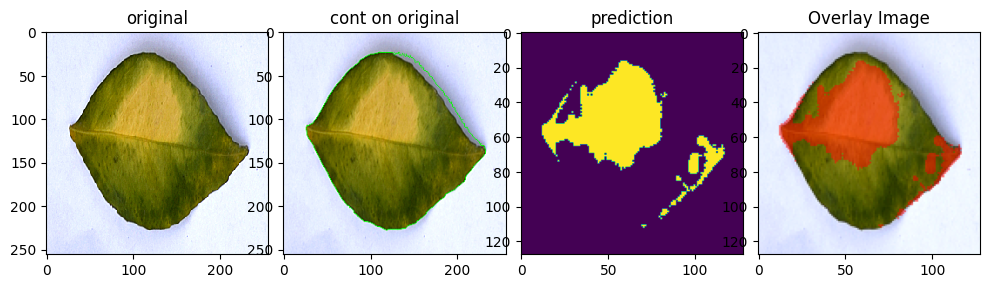

The affected area is 3601 pixels.


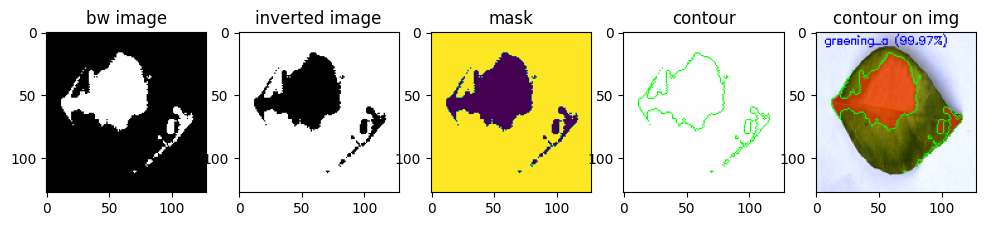

The ** **DISEASES AFFECTED area is 3601 pixels.
The total area is 3601 pixels.
Percentage of disease affected region 3601 is 13.47704859746627% of total leaf area 26719.5
Percentage of healthy region is: 86.52295140253374 


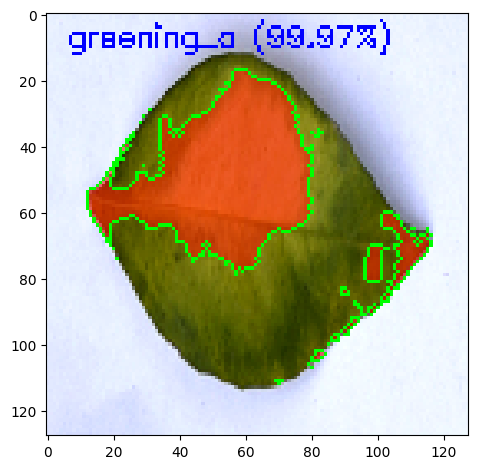

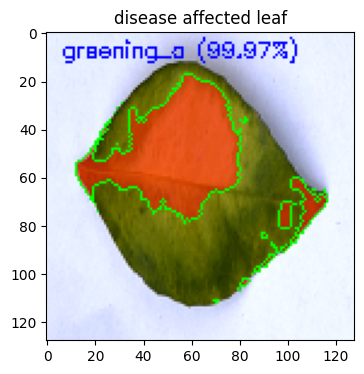

In [ ]:
from PIL import Image
import numpy as np


def overlay_mask_on_image(image, mask, alpha=0.5):
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image
# Load your image
image1 = Image.open('/content/drive/MyDrive/en_cit/greening_s/g (91).png')
image = image1
# Preprocess your image (resize if necessary, scale pixel values, etc.)
# image = image.resize((img_height, img_width))  # replace img_height and img_width with the dimensions your model expects
image = np.array(image) / 255.0  # scale pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # model.predict expects a batch of images
# image = image.numpy().astype("uint8")

# predicted_class, confidence = predict(model2, images[i].numpy())
# Use the model to predict the class
predicted_class, confidence = predict(model2, image)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")



img = image1
image1=np.array(image1)
# Convert your image to numpy array
img = np.array(img)
im = image1

# Specify the dimensions to which you want to resize your image
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize your image
img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

# Now img_resized contains your resized image


# Preprocess your image to match the format expected by your model
# preprocessed_image = preprocess_image(new_image)

# Use your model to predict the segmentation of the image
preds_new = model.predict(np.expand_dims(img_resized, axis=0), verbose=1)

# Convert the predictions into binary format
preds_new_t = (preds_new > 0.5).astype(np.uint8)
# Overlay the mask on the original image
overlay_image = overlay_mask_on_image(img_resized, preds_new_t[0])

# Display the original image and the segmented image
plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.title('original')
imshow(im)
# plt.show()
# Convert the image to grayscale
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(img, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
# Display the image
#cv2.imshow('Image', img)
#
print(f"The total area is {total_area1} pixels.")
plt.subplot(1,4,2)
plt.title('cont on original')
plt.imshow(img)
# plt.show()
# imshow(np.squeeze(preds_new_t[0]))
# plt.show()

data = np.squeeze(preds_new_t[0])
plt.subplot(1,4,3)
plt.title('prediction')
plt.imshow(data)

plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

# Load the image
image = data

plt.figure(figsize=(12, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
cv2.putText(masked_image1, f"{predicted_class} ({confidence}%)", (6, 10), cv2.FONT_ITALIC, .3, (0, 0, 255), 1)

overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


print(f"The ** **DISEASES AFFECTED area is {overlay_image_area} pixels.")
print(f"The total area is {overlay_image_area} pixels.")
percentage = (overlay_image_area/total_area1)*100
print(f"Percentage of disease affected region {overlay_image_area} is {percentage}% of total leaf area {total_area1}")
healthy = 100 - percentage
print(f"Percentage of healthy region is: {healthy} ")
# plt.subplot(1,5,4)
# plt.title('contour')
# # plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
# plt.imshow(masked_image_rgb)
# plt.subplot(1,5,5)
# plt.title('contour on img')
# plt.imshow(masked_image1)
# Display all subplots

imshow(masked_image1)
plt.show()
plt.figure(figsize=(10, 4))
plt.subplot(1,1,1)
plt.title('disease affected leaf')
plt.imshow(masked_image1)

1/1 [==============================] - 0s 20ms/step
Predicted class: canker_a with confidence: 99.95%
1/1 [==============================] - 0s 17ms/step
The total area is 25347.0 pixels.


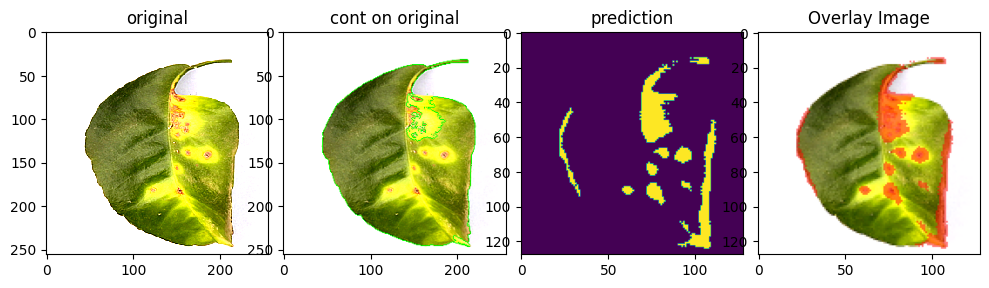

The affected area is 3601 pixels.


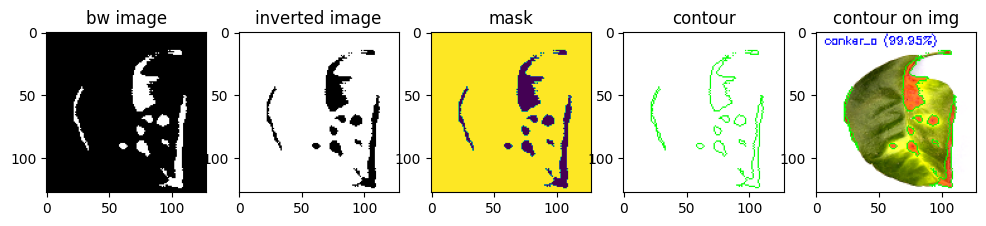

The ** **DISEASES AFFECTED area is 3601 pixels.
The total area is 3601 pixels.
Percentage of disease affected region 3601 is 14.206809484357121% of total leaf area 25347.0
Percentage of healthy region is: 85.79319051564288 


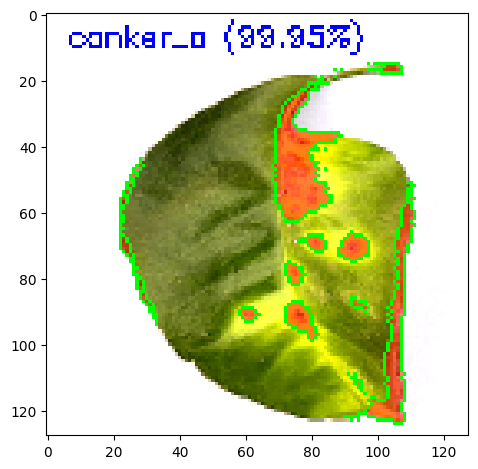

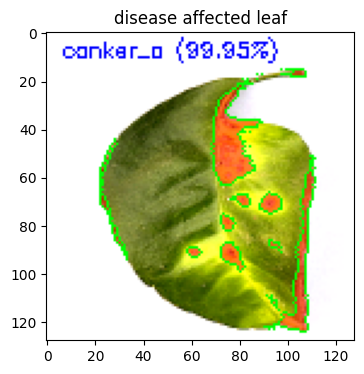

In [ ]:
from PIL import Image
import numpy as np


def overlay_mask_on_image(image, mask, alpha=0.5):
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image
# Load your image
image1 = Image.open('/content/drive/MyDrive/en_cit/canker_s/6.png.png')
image = image1
# Preprocess your image (resize if necessary, scale pixel values, etc.)
# image = image.resize((img_height, img_width))  # replace img_height and img_width with the dimensions your model expects
image = np.array(image) / 255.0  # scale pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # model.predict expects a batch of images
# image = image.numpy().astype("uint8")

# predicted_class, confidence = predict(model2, images[i].numpy())
# Use the model to predict the class
predicted_class, confidence = predict(model2, image)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")



img = image1
image1=np.array(image1)
# Convert your image to numpy array
img = np.array(img)
im = image1

# Specify the dimensions to which you want to resize your image
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize your image
img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

# Now img_resized contains your resized image


# Preprocess your image to match the format expected by your model
# preprocessed_image = preprocess_image(new_image)

# Use your model to predict the segmentation of the image
preds_new = model.predict(np.expand_dims(img_resized, axis=0), verbose=1)

# Convert the predictions into binary format
preds_new_t = (preds_new > 0.5).astype(np.uint8)
# Overlay the mask on the original image
overlay_image = overlay_mask_on_image(img_resized, preds_new_t[0])

# Display the original image and the segmented image
plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.title('original')
imshow(im)
# plt.show()
# Convert the image to grayscale
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(img, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
# Display the image
#cv2.imshow('Image', img)
#
print(f"The total area is {total_area1} pixels.")
plt.subplot(1,4,2)
plt.title('cont on original')
plt.imshow(img)
# plt.show()
# imshow(np.squeeze(preds_new_t[0]))
# plt.show()

data = np.squeeze(preds_new_t[0])
plt.subplot(1,4,3)
plt.title('prediction')
plt.imshow(data)

plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

# Load the image
image = data

plt.figure(figsize=(12, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
cv2.putText(masked_image1, f"{predicted_class} ({confidence}%)", (6, 10), cv2.FONT_ITALIC, .3, (0, 0, 255), 1)

overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


print(f"The ** **DISEASES AFFECTED area is {overlay_image_area} pixels.")
print(f"The total area is {overlay_image_area} pixels.")
percentage = (overlay_image_area/total_area1)*100
print(f"Percentage of disease affected region {overlay_image_area} is {percentage}% of total leaf area {total_area1}")
healthy = 100 - percentage
print(f"Percentage of healthy region is: {healthy} ")
# plt.subplot(1,5,4)
# plt.title('contour')
# # plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
# plt.imshow(masked_image_rgb)
# plt.subplot(1,5,5)
# plt.title('contour on img')
# plt.imshow(masked_image1)
# Display all subplots

imshow(masked_image1)
plt.show()
plt.figure(figsize=(10, 4))
plt.subplot(1,1,1)
plt.title('disease affected leaf')
plt.imshow(masked_image1)

1/1 [==============================] - 0s 21ms/step
Predicted class: canker_a with confidence: 100.0%
1/1 [==============================] - 0s 19ms/step
The total area is 2805.0 pixels.


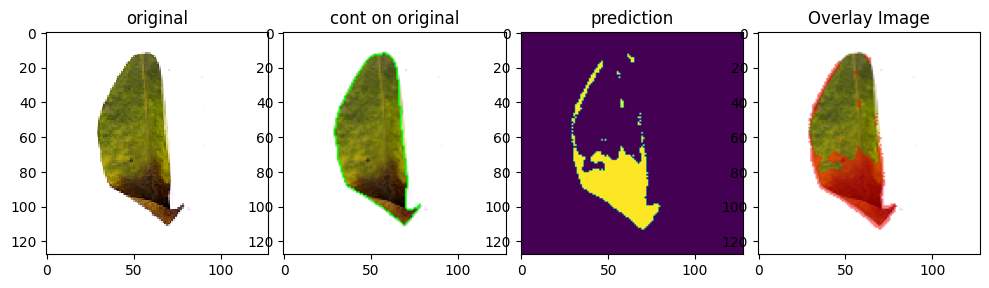

The affected area is 3601 pixels.


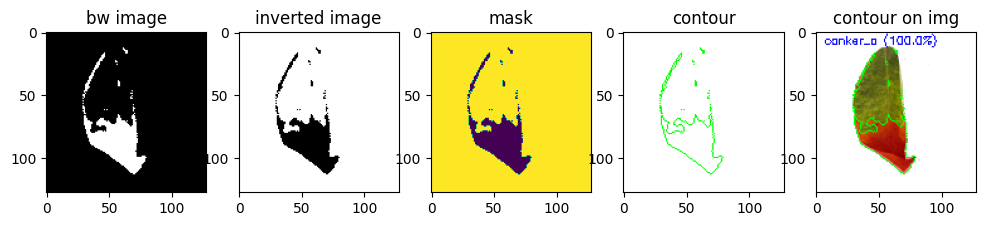

The ** **DISEASES AFFECTED area is 3601 pixels.
The total area is 3601 pixels.
Percentage of disease affected region 3601 is 128.37789661319073% of total leaf area 2805.0
Percentage of healthy region is: -28.377896613190728 


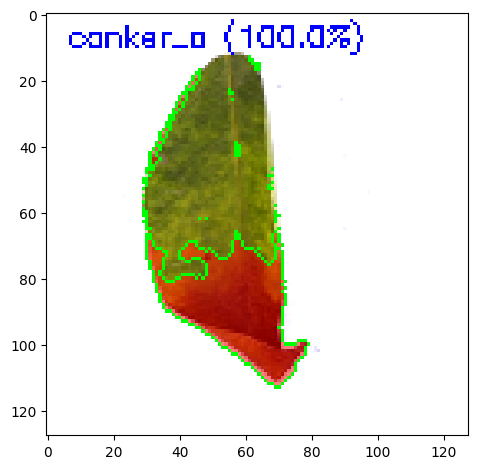

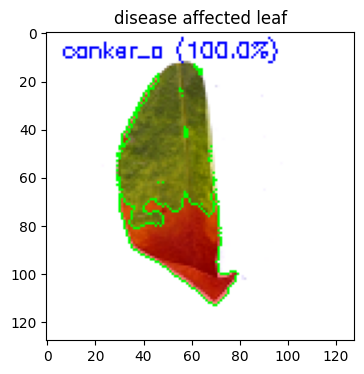

In [ ]:
from PIL import Image
import numpy as np


def overlay_mask_on_image(image, mask, alpha=0.5):
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image
# Load your image
image1 = Image.open('/content/drive/MyDrive/en_cit/blackspot_s/b (238).png')
image = image1
# Preprocess your image (resize if necessary, scale pixel values, etc.)
# image = image.resize((img_height, img_width))  # replace img_height and img_width with the dimensions your model expects
image = np.array(image) / 255.0  # scale pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # model.predict expects a batch of images
# image = image.numpy().astype("uint8")

# predicted_class, confidence = predict(model2, images[i].numpy())
# Use the model to predict the class
predicted_class, confidence = predict(model2, image)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")



img = image1
image1=np.array(image1)
# Convert your image to numpy array
img = np.array(img)
im = image1

# Specify the dimensions to which you want to resize your image
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize your image
img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
im = img_resized
# Now img_resized contains your resized image


# Preprocess your image to match the format expected by your model
# preprocessed_image = preprocess_image(new_image)

# Use your model to predict the segmentation of the image
preds_new = model.predict(np.expand_dims(img_resized, axis=0), verbose=1)

# Convert the predictions into binary format
preds_new_t = (preds_new > 0.5).astype(np.uint8)
# Overlay the mask on the original image
overlay_image = overlay_mask_on_image(img_resized, preds_new_t[0])

# Display the original image and the segmented image
plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.title('original')
imshow(im)
# plt.show()
# Convert the image to grayscale
gray1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(im, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
# Display the image
#cv2.imshow('Image', img)
#
print(f"The total area is {total_area1} pixels.")
plt.subplot(1,4,2)
plt.title('cont on original')
plt.imshow(im)
# plt.show()
# imshow(np.squeeze(preds_new_t[0]))
# plt.show()

data = np.squeeze(preds_new_t[0])
plt.subplot(1,4,3)
plt.title('prediction')
plt.imshow(data)

plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')

plt.show()

# Load the image
image = data

plt.figure(figsize=(12, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
cv2.putText(masked_image1, f"{predicted_class} ({confidence}%)", (6, 10), cv2.FONT_ITALIC, .3, (0, 0, 255), 1)

overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


print(f"The ** **DISEASES AFFECTED area is {overlay_image_area} pixels.")
print(f"The total area is {overlay_image_area} pixels.")
percentage = (overlay_image_area/total_area1)*100
print(f"Percentage of disease affected region {overlay_image_area} is {percentage}% of total leaf area {total_area1}")
healthy = 100 - percentage
print(f"Percentage of healthy region is: {healthy} ")
# plt.subplot(1,5,4)
# plt.title('contour')
# # plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
# plt.imshow(masked_image_rgb)
# plt.subplot(1,5,5)
# plt.title('contour on img')
# plt.imshow(masked_image1)
# Display all subplots

imshow(masked_image1)
plt.show()
plt.figure(figsize=(10, 4))
plt.subplot(1,1,1)
plt.title('disease affected leaf')
plt.imshow(masked_image1)